<a href="https://colab.research.google.com/github/jungmin0710/K-digital-PythonDeepLearning/blob/main/CNN_Dogs_and_Cats_VGG16_Feature_Extraction_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사전 학습된 CNN(VGG-16)을 이용한 Feature Extraction VGG-16 Model
* University of Oxford - Visual Geometry Group 
* 2014 ILSVRC 2nd Model 
* ImageNet Large Scale Visual Recognition Challenge (ILSVRC)

## 0.Import Keras

In [1]:
import keras 

keras.__version__

'2.4.3'

## 1.Google Drive Mount
* 'dogs_and_cats_small.zip' 디렉토리를 구글드라이브에 업로드

In [2]:
from google.colab import drive 

drive.mount('/content/drive')

Mounted at /content/drive


### 1) 구글 드라이브 마운트 결과 확인

In [3]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'

-rw------- 1 root root 90618980 Mar  4 04:51 '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'


### 2) unzip 'dogs_and_cats_small.zip'

In [4]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/dogs_and_cats_small.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip
  inflating: test/cats/cat.1501.jpg  
  inflating: test/cats/cat.1502.jpg  
  inflating: test/cats/cat.1503.jpg  
  inflating: test/cats/cat.1504.jpg  
  inflating: test/cats/cat.1505.jpg  
  inflating: test/cats/cat.1506.jpg  
  inflating: test/cats/cat.1507.jpg  
  inflating: test/cats/cat.1508.jpg  
  inflating: test/cats/cat.1509.jpg  
  inflating: test/cats/cat.1510.jpg  
  inflating: test/cats/cat.1511.jpg  
  inflating: test/cats/cat.1512.jpg  
  inflating: test/cats/cat.1513.jpg  
  inflating: test/cats/cat.1514.jpg  
  inflating: test/cats/cat.1515.jpg  
  inflating: test/cats/cat.1516.jpg  
  inflating: test/cats/cat.1517.jpg  
  inflating: test/cats/cat.1518.jpg  
  inflating: test/cats/cat.1519.jpg  
  inflating: test/cats/cat.1520.jpg  
  inflating: test/cats/cat.1521.jpg  
  inflating: test/cats/cat.1522.jpg  
  inflating: test/cats/cat.1523.jpg  
  inflating: test/cats/cat.1524.jpg  
  inf

In [5]:
!ls -l

total 20
drwx------ 5 root root 4096 Mar 24 04:55 drive
drwxr-xr-x 1 root root 4096 Mar 18 13:36 sample_data
drwxr-xr-x 4 root root 4096 Mar 24 04:56 test
drwxr-xr-x 4 root root 4096 Mar 24 04:56 train
drwxr-xr-x 4 root root 4096 Mar 24 04:56 validation


## 2.Image_File Directory Setting
* train_dir 
* valid_dir 
* test_dir

In [6]:
train_dir = 'train' 
valid_dir = 'validation' 
test_dir = 'test'

## 3.Import VGG-16 Model

### 1) conv_base

In [7]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', 
                  include_top = False, 
                  input_shape = (150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


### 2) Model Information

In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## 4.Feature Extraction

### 1) 특징추출 함수 정의 : extract_feature( )
* conv_base.predict( )

In [9]:
from keras.preprocessing.image import ImageDataGenerator 
import numpy as np

datagen = ImageDataGenerator(rescale = 1./255) 

batch_size = 20

def extract_features(directory, sample_count): 
  features = np.zeros(shape = (sample_count, 4, 4, 512)) 
  labels = np.zeros(shape = (sample_count))

  generator = datagen.flow_from_directory(directory,
                                          target_size = (150, 150), 
                                          batch_size = batch_size, 
                                          class_mode = 'binary')
  
  i = 0 
  for inputs_batch, labels_batch in generator: 
    features_batch = conv_base.predict(inputs_batch) 
    features[i * batch_size : (i + 1) * batch_size] = features_batch 
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch 
    i += 1 
    if i * batch_size >= sample_count: 
      break
  return features, labels

### 2) 특징추출 함수 적용
* train_dir 
* valid_dir 
* test_dir

In [10]:
%%time
train_features, train_labels = extract_features(train_dir, 2000) 
valid_features, valid_labels = extract_features(valid_dir, 1000) 
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
CPU times: user 22.6 s, sys: 4.68 s, total: 27.3 s
Wall time: 54.9 s


In [11]:
train_features.shape, valid_features.shape, test_features.shape

((2000, 4, 4, 512), (1000, 4, 4, 512), (1000, 4, 4, 512))

### 3) Reshape Features 
* For 'Classification' Network

In [12]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512)) 
valid_features = np.reshape(valid_features, (1000, 4 * 4 * 512)) 
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

train_features.shape, valid_features.shape, test_features.shape

((2000, 8192), (1000, 8192), (1000, 8192))

## 5.Keras CNN Modeling with VGG-16 Featured Data

### 1) Model Define
* 'Classification' Network Only
* Dropout Layer

In [13]:
from keras import models, layers

model = models.Sequential() 
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512)) 
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(1, activation = 'sigmoid'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


### 2) Model Compile 
* 모델 학습방법 설정

In [15]:
model.compile(loss = 'binary_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

### 3) Model Fit

In [16]:
%%time

Hist_dandc = model.fit(train_features, train_labels, 
                       epochs = 100, 
                       batch_size = 20,
                       validation_data = (valid_features, valid_labels))

Epoch 1/100
100/100 [==============================] - 1s 9ms/step - loss: 0.8135 - accuracy: 0.6740 - val_loss: 0.2913 - val_accuracy: 0.8700
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 0.2427 - accuracy: 0.8987 - val_loss: 0.2522 - val_accuracy: 0.8970
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.2052 - accuracy: 0.9141 - val_loss: 0.2734 - val_accuracy: 0.8830
Epoch 4/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1890 - accuracy: 0.9278 - val_loss: 0.2477 - val_accuracy: 0.9000
Epoch 5/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1347 - accuracy: 0.9481 - val_loss: 0.2842 - val_accuracy: 0.8740
Epoch 6/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1197 - accuracy: 0.9456 - val_loss: 0.3270 - val_accuracy: 0.8840
Epoch 7/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1014 - accuracy: 0.9628 - val_loss: 0.2935 - val_accuracy: 0.8900

### 4) 학습 결과 시각화 
* Loss Visualization

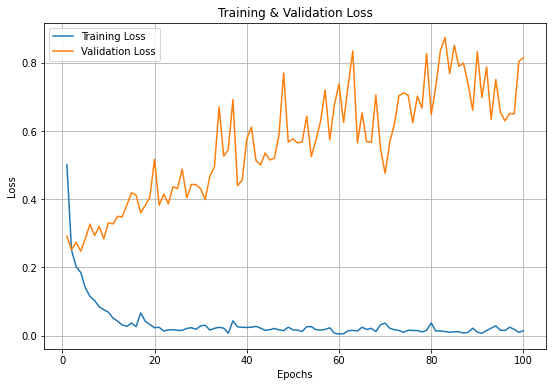

In [17]:
import matplotlib.pyplot as plt 

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6)) 
plt.plot(epochs, Hist_dandc.history['loss']) 
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend(['Training Loss', 'Validation Loss']) 
plt.grid() 
plt.show()

* Accuracy Visualization

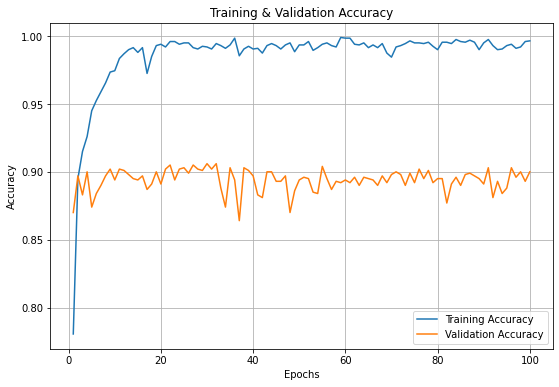

In [18]:
import matplotlib.pyplot as plt 

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6)) 
plt.plot(epochs, Hist_dandc.history['accuracy']) 
plt.plot(epochs, Hist_dandc.history['val_accuracy'])

plt.title('Training & Validation Accuracy') 
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.legend(['Training Accuracy', 'Validation Accuracy']) 
plt.grid() 
plt.show()

### 5) Model Evaluate
* Loss & Accuracy

In [19]:
loss, accuracy = model.evaluate(test_features, test_labels)

print('Loss = {:.5f}'.format(loss)) 
print('Accuracy = {:.5f}'.format(accuracy))

32/32 [==============================] - 0s 3ms/step - loss: 0.9339 - accuracy: 0.8810
Loss = 0.93391
Accuracy = 0.88100


## 4.Model Save & Load to Google Drive

### 1) Google Drive Mount

In [20]:
from google.colab import drive 

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2) Model Save

In [22]:
model.save('/content/drive/My Drive/Colab Notebooks/models/004_dogs_and_cats_feature_extraction.h5')

In [23]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 105697
-rw------- 1 root root    34592 Mar 17 07:50 001_Model_iris.h5
-rw------- 1 root root 41498896 Mar 23 02:25 002_dogs_and_cats_small.h5
-rw------- 1 root root 41499744 Mar 23 06:22 003_dogs_and_cats_augmentation.h5
-rw------- 1 root root 25199032 Mar 24 05:11 004_dogs_and_cats_feature_extraction.h5


### 3) Model Load

In [26]:
from keras.models import load_model 

model_google = load_model('/content/drive/My Drive/Colab Notebooks/models/004_dogs_and_cats_feature_extraction.h5')

In [28]:
loss, accuracy = model_google.evaluate(test_features, test_labels)

print('Loss = {:.5f}'.format(loss)) 
print('Accuracy = {:.5f}'.format(accuracy))

32/32 [==============================] - 0s 3ms/step - loss: 0.9339 - accuracy: 0.8810
Loss = 0.93391
Accuracy = 0.88100


본 내용은 2021/03/24(수)에 학습한 내용입니다.